OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [289]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [290]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [291]:
from functions import *

#### Loading dataset

In [292]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
#  "Neighborhood",
category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'Neighborhood': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [293]:
path = "./dataset/cleaned/"
filename = "2016_Building_Energy_Prediction.csv"

dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type
data = pd.read_csv(dataset_path, dtype=category_types, sep=",")

In [294]:
data.shape

(3131, 29)

In [295]:
data.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

In [296]:
data.select_dtypes(['category']).nunique().sort_values()

CouncilDistrictCode              7
BuildingType                     8
Neighborhood                    13
PrimaryPropertyType             23
ThirdLargestPropertyUseType     44
SecondLargestPropertyUseType    51
ZipCode                         54
LargestPropertyUseType          55
dtype: int64

In [297]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [298]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUse(kBtu)',
       'Log2-SteamUse(kBtu)', 'Log2-Electricity(kBtu)',
       'Log2-NaturalGas(kBtu)', 'Log2-TotalGHGEmissions'],
      dtype='object')

In [299]:
from test import *
data = mapping_property_use_type(data, property_use_types_columns, usetype_dict)

Before
CouncilDistrictCode              7
BuildingType                     8
Neighborhood                    13
PrimaryPropertyType             23
ThirdLargestPropertyUseType     44
SecondLargestPropertyUseType    51
ZipCode                         54
LargestPropertyUseType          55
dtype: int64
After
CouncilDistrictCode              7
BuildingType                     8
Neighborhood                    13
PrimaryPropertyType             19
ThirdLargestPropertyUseType     20
SecondLargestPropertyUseType    21
LargestPropertyUseType          25
ZipCode                         54
dtype: int64


In [300]:
#features_for_prediction = ["YearBuilt",  "BuildingType","PrimaryPropertyType", "Neighborhood", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

features_for_prediction = ["YearBuilt", "NumberofBuildings", "NumberofFloors", "LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)",
                           "Neighborhood", "BuildingType","PrimaryPropertyType", "LargestPropertyUseType"]

#variables_to_predict = ["SiteEnergyUse(kBtu)", "Log2-SiteEnergyUse(kBtu)"]
variables_to_predict = ["Log2-SiteEnergyUse(kBtu)"]

features_for_prediction.extend(variables_to_predict)
print(features_for_prediction)

['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'Neighborhood', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'Log2-SiteEnergyUse(kBtu)']


In [301]:
data = data[features_for_prediction]

data

,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Log2-SiteEnergyUse(kBtu)
0,1978,1.0,3,17628.0,20739,central,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing,19.638743
1,1928,1.0,2,14150.0,25955,greater duwamish,NonResidential,Warehouse,Non-Refrigerated Warehouse,20.216217
2,1925,1.0,3,25120.0,25120,greater duwamish,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing,19.161427
3,1971,1.0,15,79912.0,73898,greater duwamish,Multifamily HR (10+),Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,21.619415
4,2001,1.0,3,25153.0,29353,greater duwamish,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing,19.874160
...,...,...,...,...,...,...,...,...,...,...
3126,2001,5.0,3,14273.0,32601,lake union,NonResidential,Mixed Use Property,Hotel/Senior Care/Housing,21.999679
3127,1907,1.0,4,36660.0,36660,lake union,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing,19.827444
3128,2001,1.0,5,15908.0,27730,lake union,NonResidential,Small- and Mid-Sized Office,Office,20.300511
3129,1911,1.0,2,10155.0,20516,lake union,NonResidential,Retail,Retail,19.962678


## I) Feature Engineering : preparing the vectors and matrices


#### 1) Separating training data and target vector

In [302]:
# we create the data matrix / we only take the features
X = data[data.columns[:-len(variables_to_predict)]]

# we create the target vector
y = data[variables_to_predict].values # numpy array not a DataFrame anymore

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

Shape of X : (3131, 9)
Shape of y : (3131, 1)


In [303]:
X

,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType
0,1978,1.0,3,17628.0,20739,central,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
1,1928,1.0,2,14150.0,25955,greater duwamish,NonResidential,Warehouse,Non-Refrigerated Warehouse
2,1925,1.0,3,25120.0,25120,greater duwamish,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
3,1971,1.0,15,79912.0,73898,greater duwamish,Multifamily HR (10+),Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
4,2001,1.0,3,25153.0,29353,greater duwamish,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
...,...,...,...,...,...,...,...,...,...
3126,2001,5.0,3,14273.0,32601,lake union,NonResidential,Mixed Use Property,Hotel/Senior Care/Housing
3127,1907,1.0,4,36660.0,36660,lake union,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
3128,2001,1.0,5,15908.0,27730,lake union,NonResidential,Small- and Mid-Sized Office,Office
3129,1911,1.0,2,10155.0,20516,lake union,NonResidential,Retail,Retail


In [304]:
print("We check that we do not have missing values :", data.isna().sum().sum())

We check that we do not have missing values : 0


#### 2) Separation train and test dataset


In [305]:
print("We have to separate the train / test sets before normalising the dataset.")

We have to separate the train / test sets before normalising the dataset.


In [306]:
# We create a training set and a test set (the test set contains 30% of the dataset)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,  random_state=42)

In [307]:
X_train.shape

(2191, 9)

In [308]:
X_test.shape

(940, 9)

#### 3) Normalization

In [309]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [310]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [311]:
X.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(include='number').columns.drop("YearBuilt")
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (4,)
Shape of numerical variables : (4,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [312]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 4 numerical features to standardize.

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'PropertyGFABuilding(s)'],
      dtype='object')


In [313]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scale = StandardScaler().fit(X_train[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = std_scale.transform(X_train[numerical_columns])
X_test_std[numerical_columns] = std_scale.transform(X_test[numerical_columns])

print("Before")
display(X_train)
print("After")
display(X_train_std)

Before


,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType
2091,1922,1.0,11,67390.0,66990,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
2071,1930,1.0,20,83591.0,88591,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
964,1929,1.0,3,21886.0,27908,northeast,Nonresidential COS,Other,Other
2218,1970,1.0,7,93905.0,94002,lake union,NonResidential,Small- and Mid-Sized Office,Office
2737,1929,1.0,3,24276.0,32908,magnolia / queen anne,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
...,...,...,...,...,...,...,...,...,...
3092,1986,1.0,3,40067.0,40067,magnolia / queen anne,NonResidential,Small- and Mid-Sized Office,Office
1095,2012,1.0,7,60084.0,74421,northeast,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1130,2014,1.0,8,275443.0,439262,ballard,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1294,1998,1.0,5,27180.0,33274,east,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing


After


,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType
2091,1922,-0.108665,1.165681,-0.045538,-0.110564,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
2071,1930,-0.108665,2.831097,0.102354,0.075324,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
964,1929,-0.108665,-0.314688,-0.460922,-0.446885,northeast,Nonresidential COS,Other,Other
2218,1970,-0.108665,0.425496,0.196505,0.121888,lake union,NonResidential,Small- and Mid-Sized Office,Office
2737,1929,-0.108665,-0.314688,-0.439105,-0.403857,magnolia / queen anne,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
...,...,...,...,...,...,...,...,...,...
3092,1986,-0.108665,-0.314688,-0.294956,-0.342250,magnolia / queen anne,NonResidential,Small- and Mid-Sized Office,Office
1095,2012,-0.108665,0.425496,-0.112231,-0.046617,northeast,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1130,2014,-0.108665,0.610543,1.853680,3.093028,ballard,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1294,1998,-0.108665,0.055404,-0.412596,-0.400708,east,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing


We can check that the numerical variables have a Standard Normal distribution.


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

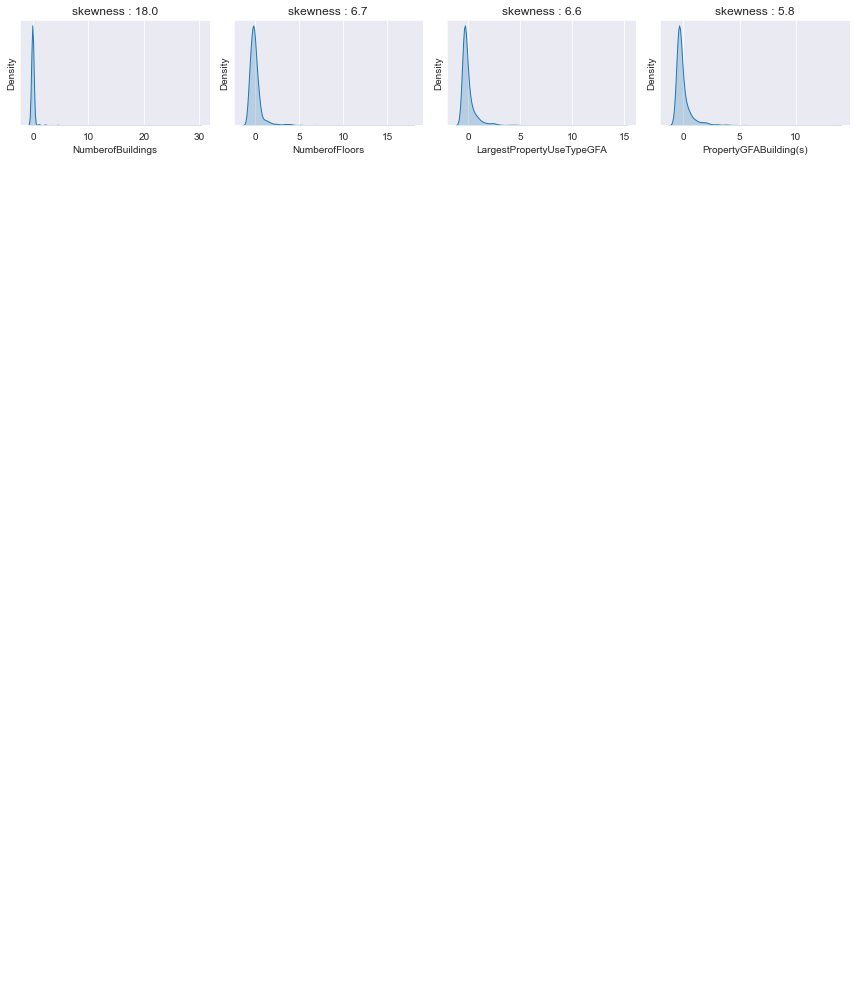

In [314]:
print("We can check that the numerical variables have a Standard Normal distribution.")
densite(X_train_std[numerical_columns])

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


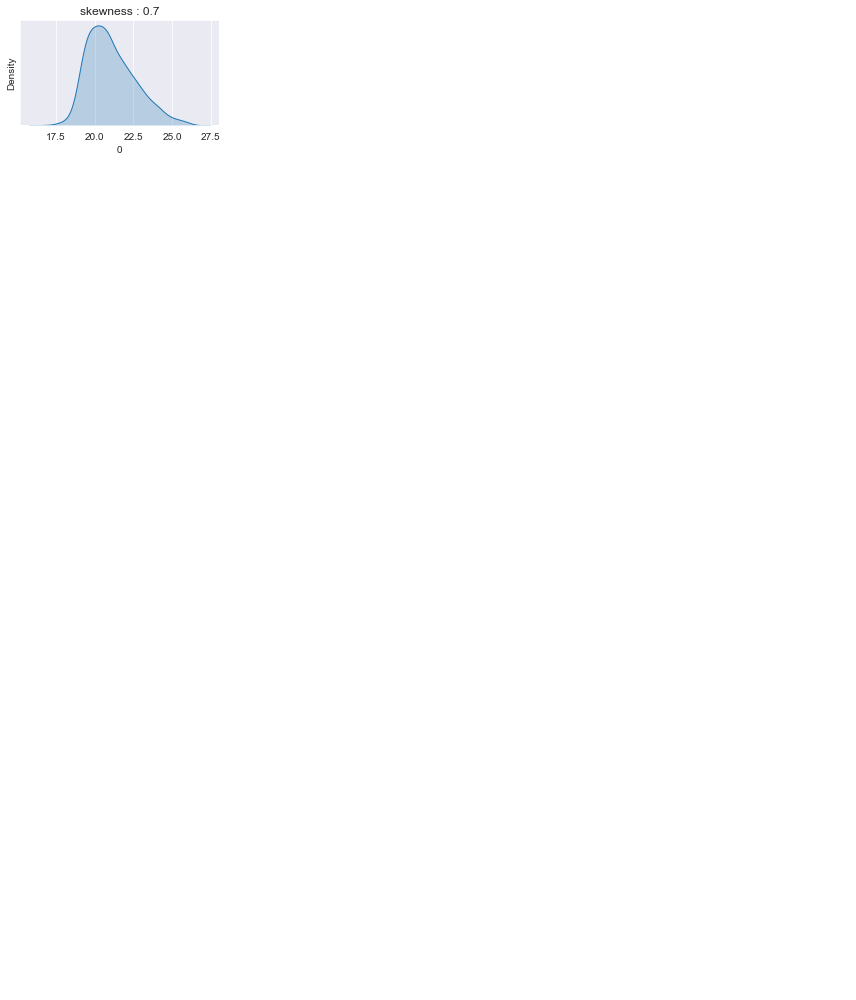

In [315]:
densite(pd.DataFrame(y_train))

##### 2) Feature Encoding : One Hot Encoder

In [316]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 4 categorical features to encode.

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType'],
      dtype='object')


In [317]:
X.dtypes # we check that we have categories

YearBuilt                       int64
NumberofBuildings             float64
NumberofFloors                  int64
LargestPropertyUseTypeGFA     float64
PropertyGFABuilding(s)          int64
Neighborhood                 category
BuildingType                 category
PrimaryPropertyType          category
LargestPropertyUseType       category
dtype: object

In [318]:
X[categorical_columns].nunique().sort_values()

BuildingType               8
Neighborhood              13
PrimaryPropertyType       19
LargestPropertyUseType    25
dtype: int64

In [319]:
X_train_std[categorical_columns]

,Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType
2091,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
2071,downtown,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing
964,northeast,Nonresidential COS,Other,Other
2218,lake union,NonResidential,Small- and Mid-Sized Office,Office
2737,magnolia / queen anne,Multifamily LR (1-4),Low-Rise Multifamily,Hotel/Senior Care/Housing
...,...,...,...,...
3092,magnolia / queen anne,NonResidential,Small- and Mid-Sized Office,Office
1095,northeast,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1130,ballard,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing
1294,east,Multifamily MR (5-9),Mid-Rise Multifamily,Hotel/Senior Care/Housing


##### Encoding the categorical features of the train set


In [320]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([X[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 65 columns to encodes the categorical features.


In [321]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(X_train_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(X_train_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
X_train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=X_train_std.index)
display(X_train_encoded.sort_index())

We have indeed : 63 labels after encoding the categorical variables.


,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
# 5) Concatenate the two dataframes for the training set

print("We need to add YearBuilt to the list of features.")
numerical_columns.tolist()
features_to_merge = numerical_columns.tolist().copy()
features_to_merge.append("YearBuilt")
print(features_to_merge, end="\n\n")

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_train_std_encoded = pd.merge(X_train_std[features_to_merge].sort_index(), X_train_encoded.sort_index(), left_index=True, right_index=True)
display(X_train_std_encoded.sort_index())

We need to add YearBuilt to the list of features.
['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'YearBuilt']

ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
1,-0.108665,-0.499734,-0.531541,-0.463691,1928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.108665,-0.314688,-0.431401,-0.470877,1925,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.108665,1.905866,0.068770,-0.051117,1971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.108665,-0.314688,-0.431099,-0.434450,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.108665,-0.129642,-0.305071,-0.351785,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,-0.108665,0.055404,-0.241025,-0.234225,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.108665,-0.499734,-0.489641,-0.395837,1927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,4.469907,-0.314688,-0.530418,-0.406499,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,-0.108665,0.055404,-0.515493,-0.448417,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding the categorical features of the test set

In [323]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(X_test_std[categorical_columns])

print("ASK JEREMY for this method below ???")
# 5.2) we recreate a dataframe with the column names and the numpy array
X_test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=X_test_std.index)
display(X_test_encoded.sort_index())

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_test_std_encoded = pd.merge(X_test_std[features_to_merge].sort_index(), X_test_encoded.sort_index(), left_index=True, right_index=True)
display(X_test_std_encoded.sort_index())

ASK JEREMY for this method below ???


,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
0,-0.108665,-0.314688,-0.499792,-0.508578,1978,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.108665,-0.314688,0.237145,0.351647,1977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.108665,-0.499734,-0.390140,-0.458322,1991,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,-0.108665,-0.129642,-0.225205,0.670249,2010,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.108665,-0.684781,-0.400820,-0.423461,1980,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,-0.108665,0.240450,-0.053416,0.147515,2007,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,-0.108665,0.055404,-0.364397,-0.407713,1915,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.108665,-0.129642,-0.297759,-0.344892,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.108665,-0.129642,-0.326057,-0.371569,1907,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [324]:
# Save
X_train_std_encoded.to_csv("dataset/cleaned/electricity/X_train.csv", index=False)
X_test_std_encoded.to_csv("dataset/cleaned/electricity/X_test.csv", index=False)
#y_train.to_csv("dataset/cleaned/electricity/y_train.csv", index=False)
#y_test.to_csv("dataset/cleaned/electricity/y_test.csv", index=False)

## II) Modelisation

In [325]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [326]:
print("We can start now the modelling to predict the feature wanted.")

display(X_train_std_encoded)
display(X_test_std_encoded)
print(y_train.shape, y_test.shape)

We can start now the modelling to predict the feature wanted.


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
1,-0.108665,-0.499734,-0.531541,-0.463691,1928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.108665,-0.314688,-0.431401,-0.470877,1925,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.108665,1.905866,0.068770,-0.051117,1971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.108665,-0.314688,-0.431099,-0.434450,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.108665,-0.129642,-0.305071,-0.351785,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,-0.108665,0.055404,-0.241025,-0.234225,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.108665,-0.499734,-0.489641,-0.395837,1927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,4.469907,-0.314688,-0.530418,-0.406499,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,-0.108665,0.055404,-0.515493,-0.448417,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
0,-0.108665,-0.314688,-0.499792,-0.508578,1978,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.108665,-0.314688,0.237145,0.351647,1977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.108665,-0.499734,-0.390140,-0.458322,1991,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,-0.108665,-0.129642,-0.225205,0.670249,2010,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.108665,-0.684781,-0.400820,-0.423461,1980,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,-0.108665,0.240450,-0.053416,0.147515,2007,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,-0.108665,0.055404,-0.364397,-0.407713,1915,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.108665,-0.129642,-0.297759,-0.344892,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.108665,-0.129642,-0.326057,-0.371569,1907,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2191, 1) (940, 1)


In [327]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [328]:
print("We rename X_train_std_encoded to X_train, the same for X_test.")
X_train = X_train_std_encoded.copy()
X_test = X_test_std_encoded.copy()

X_train
X_test

We rename X_train_std_encoded to X_train, the same for X_test.


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
0,-0.108665,-0.314688,-0.499792,-0.508578,1978,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.108665,-0.314688,0.237145,0.351647,1977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.108665,-0.499734,-0.390140,-0.458322,1991,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,-0.108665,-0.129642,-0.225205,0.670249,2010,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.108665,-0.684781,-0.400820,-0.423461,1980,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,-0.108665,0.240450,-0.053416,0.147515,2007,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,-0.108665,0.055404,-0.364397,-0.407713,1915,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.108665,-0.129642,-0.297759,-0.344892,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.108665,-0.129642,-0.326057,-0.371569,1907,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1) Linear modelling : Linear Regression / Ridge Regression / Lasso / Elastic Net


In [329]:
X_train.shape

(2191, 68)

In [330]:
X_test.shape

(940, 68)

#### 1) Linear Regression : baseline

In [331]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)

prediction_score = lr.score(X_test, y_test)
#print("Accuracy is : %.2f" % (100 * prediction_score))
print('Accuracy is : {:.0%}'.format(prediction_score))

Accuracy is : -3%


In [332]:
# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_pred = lr.predict(X_test)
baseline_error = np.mean((y_pred - y_test) ** 2)

#On obtient l'erreur quadratique ci-dessous
print(baseline_error)

2.6829013263176056


In [333]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

def run_experiment(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R² : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

run_experiment(lr)

R² :  -0.02526623014487628
MAE : 1.3086566504509394
RMSE: 1.6379564482359126


In [334]:
y_test

array([[22.26769411],
       [19.1804437 ],
       [20.07479038],
       [22.18275289],
       [20.04681161],
       [19.09221613],
       [23.80906626],
       [21.64914608],
       [19.36773227],
       [19.53470884],
       [18.8320546 ],
       [25.42292366],
       [25.66400485],
       [19.83089842],
       [19.81195103],
       [20.03366177],
       [22.99753752],
       [20.64743778],
       [21.05396034],
       [23.77569135],
       [20.0565552 ],
       [19.56519542],
       [20.0452504 ],
       [20.84133697],
       [22.59719112],
       [22.53052803],
       [18.99612338],
       [21.47644388],
       [25.66164234],
       [19.90585383],
       [20.98875385],
       [21.64340715],
       [23.13793423],
       [21.38444624],
       [19.69271829],
       [17.86647423],
       [20.09312222],
       [18.5489611 ],
       [19.74589227],
       [19.60661373],
       [20.68213724],
       [23.48460031],
       [22.54894429],
       [19.56385296],
       [22.2741162 ],
       [20

['Log2-SiteEnergyUse(kBtu)'] prediction


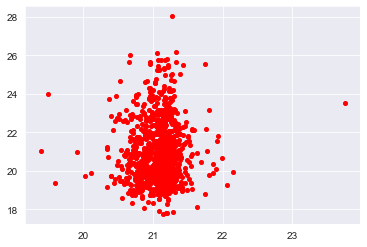

If the prediction was good, we would see a line which is not the case here .


In [335]:
print(variables_to_predict, "prediction")
plt.plot(y_pred, y_test, "ro", markersize=4)
plt.show()

print("If the prediction was good, we would see a line which is not the case here .")

#### 2) Linear Model : Ridge

In [336]:
n_alphas = 50 #hyperparametre alpha
alphas = np.logspace(-5, 5, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test) - y_test) ** 2))

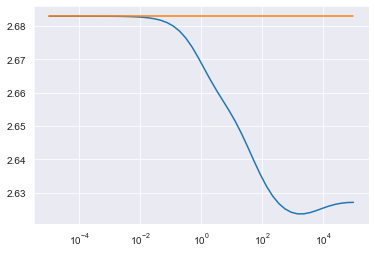

In [337]:
# observation du comportement de l'erreur

ax = plt.gca()
ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.show()

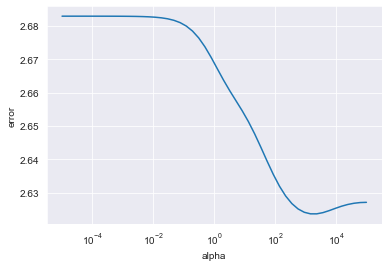

In [338]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [339]:
# index du min des erreurs
np.argmin(errors)

41

In [340]:
# recupere l'erreur min
errors[np.argmin(errors)]

2.6236987132383227

#### 3) Linear Model : LASSO

#### 4) Linear Model : Elastic Net

In [341]:
from sklearn.linear_model import ElasticNet

#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge


elastic_grid = GridSearchCV(estimator = ElasticNet(),
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv=5,
                            verbose=0
                            )

elastic_grid.fit(X_train, y_train)

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 4.108e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.492e+00, tolerance: 4.340e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e+03, tolerance: 4.278e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e+03, tolerance: 4.306e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implem

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [342]:
elastic_grid.best_params_

{'alpha': 1, 'l1_ratio': 0.0, 'tol': 0.1}

{'alpha': 1, 'l1_ratio': 0.0, 'tol': 0.1}

In [343]:
results = pd.DataFrame({})

import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
    ignore_index=True)

C:\Users\athen\AppData\Local\Temp\ipykernel_25316\1635556635.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({
C:\Users\athen\AppData\Local\Temp\ipykernel_25316\1635556635.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [344]:
results

,Modèle,Score_RMSE
0,Elasticnet Regression,1.619777


,Modèle,Score_RMSE
0,Elasticnet Regression,1.619777


### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [345]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest

In [346]:
X_train

,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
1,-0.108665,-0.499734,-0.531541,-0.463691,1928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.108665,-0.314688,-0.431401,-0.470877,1925,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.108665,1.905866,0.068770,-0.051117,1971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.108665,-0.314688,-0.431099,-0.434450,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.108665,-0.129642,-0.305071,-0.351785,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,-0.108665,0.055404,-0.241025,-0.234225,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.108665,-0.499734,-0.489641,-0.395837,1927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,4.469907,-0.314688,-0.530418,-0.406499,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,-0.108665,0.055404,-0.515493,-0.448417,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,NumberofBuildings,NumberofFloors,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),YearBuilt,Neighborhood_ballard,Neighborhood_central,Neighborhood_delridge,Neighborhood_downtown,Neighborhood_east,...,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Police Station,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Retail,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
1,-0.108665,-0.499734,-0.531541,-0.463691,1928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.108665,-0.314688,-0.431401,-0.470877,1925,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.108665,1.905866,0.068770,-0.051117,1971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.108665,-0.314688,-0.431099,-0.434450,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.108665,-0.129642,-0.305071,-0.351785,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,-0.108665,0.055404,-0.241025,-0.234225,1925,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.108665,-0.499734,-0.489641,-0.395837,1927,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,4.469907,-0.314688,-0.530418,-0.406499,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,-0.108665,0.055404,-0.515493,-0.448417,2001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
rfr = rfr.fit(X_train.values, y_train)

C:\Users\athen\AppData\Local\Temp\ipykernel_25316\100436821.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr = rfr.fit(X_train.values, y_train)
C:\Users\athen\AppData\Local\Temp\ipykernel_25316\100436821.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr = rfr.fit(X_train.values, y_train)


In [348]:
from sklearn.metrics import accuracy_score
import timeit

start_time = timeit.default_timer()

pred = rfr.predict(X_test.values)

elapsed = timeit.default_timer() - start_time

accuracy = rfr.score(X_test.values, y_test)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))


accuracy -0.12 time 0.21s
accuracy -0.12 time 0.76s


In [349]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rfr, prefit=True, threshold=0.01)
X_train2 = model.transform(X_train.values)
X_train2.shape

(2191, 12)

(2191, 12)

In [350]:
run_experiment(rfr)

"""
R² :  -0.036410020297567236
MAE : 1.3407748367227499
RMSE: 1.698681454232116
"""

C:\Users\athen\AppData\Local\Temp\ipykernel_25316\2696432212.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


R² :  -0.11646226656618519
MAE : 1.3710267270816785
RMSE: 1.7092518098666527


'\nR² :  -0.036410020297567236\nMAE : 1.3407748367227499\nRMSE: 1.698681454232116\n'

C:\Users\athen\AppData\Local\Temp\ipykernel_25316\2696432212.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


R² :  -0.11707204223174394
MAE : 1.370034521472689
RMSE: 1.7097185152439007


'\nR² :  -0.036410020297567236\nMAE : 1.3407748367227499\nRMSE: 1.698681454232116\n'

In [351]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

In [283]:
rfr_search = GridSearchCV(RandomForestRegressor(),
                          param_grid = parameters,
                          #scoring='mean_squared_error',
                          verbose=2,
                          cv=5)

rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   1.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   3.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   3.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   3.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   4.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   4.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   6.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=  17.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=  17.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=  18.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=  17.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=  17.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   1.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   1.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   1.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   1.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   1.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   2.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   2.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   2.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   2.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   2.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   4.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.5s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   4.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=  10.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   6.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   6.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   6.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   6.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   5.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=  10.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=  10.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=  10.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=  10.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   9.8s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   3.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   3.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   3.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=500; total time=   5.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=500; total time=   5.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=500; total time=   5.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=500; total time=   5.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=500; total time=   5.3s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=300; total time=   2.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=300; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=500; total time=   3.4s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=300; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   3.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   3.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   3.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   3.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   3.1s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   1.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   2.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   3.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   3.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   2.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   7.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.2s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   1.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.4s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.6s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.7s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   2.9s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   2.8s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686:

[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.3s


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [284]:
rfr_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}

In [285]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(rfr_search.predict(X_test), y_test))]}),
    ignore_index=True)

C:\Users\athen\AppData\Local\Temp\ipykernel_25316\3996465591.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [286]:
coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']),
                             pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

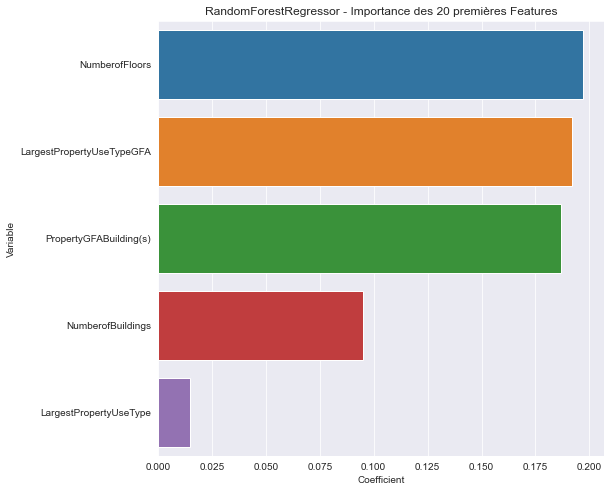

In [287]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [288]:
results

,Modèle,Score_RMSE
0,Elasticnet Regression,1.619777
1,Random Forest Regressor,1.630332


#### 2) Sequence Tree : XGBoost

#### Export des modèles pour réutilisation ultérieure


#### Chargement des modèles


#### Comparaison des modèles


### III) Evaluation

#### Vérification des prédictions


#### Intérêt du Energy Star Score
